# HW12 - Extra Credit - Making a Semivariogram based on asthma dismissal records

## Author: Avikal Somvanshi


In [7]:
# Improting packages
import ast
import urllib2
import urllib
from cStringIO import StringIO
import json
import geopandas as gpd
import pandas as pd
import zipfile
import matplotlib
import pylab as pl
import numpy as np
from scipy.spatial.distance import pdist, squareform
import os
import seaborn
%matplotlib inline


In [2]:
#downloading asthma records with an SQL query provided in the instructions

SQL_SOURCE = 'https://fb55.carto.com/api/v2/sql'

def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    """ queries a url with an sql compatible search
    Arguments:
    query : the sql query string
    format : the expected format
    source " the url of the API
    """
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

In [3]:
# fill in the query details in facilityQuery: 
# within a single query collect AND GROUP the data by zipcode
facilityQuery = '''
SELECT 
COUNT (*) as count,
zipcodes
FROM nycasthmasdismissals
GROUP BY zipcodes;'''
facilityStream = queryCartoDB(facilityQuery, format='JSON')
facilityData   = json.loads(facilityStream.read())
facilityData
facilities     = pd.DataFrame.from_dict(facilityData['rows'])
facilities

,count,zipcodes
0,1699,10461
1,405,11373
2,1698,10451
3,220,11691
4,246,11375
5,494,10466
6,713,11212
7,167,11229
8,521,11215
9,386,11220


# Uploading the ZipShapeFile

In [11]:
#the shape file was downloaded and saved in the folder
#uploading 
nyc_shape = zipfile.ZipFile('ZIP_CODE_040114.zip')
nyc_shape.extractall('shape')
nyc_shape.close()

In [12]:
newyork=gpd.read_file('shape/ZIP_CODE_040114.shp')

In [13]:
newyork.head(n=1)

,AREA,BLDGZIP,COUNTY,CTY_FIPS,POPULATION,PO_NAME,SHAPE_AREA,SHAPE_LEN,STATE,ST_FIPS,URL,ZIPCODE,geometry
0,2.269930e+07,0,Queens,081,18681.0,Jamaica,0.0,0.0,NY,36,http://www.usps.com/,11436,"POLYGON ((1038098.251871482 188138.3800067157,..."


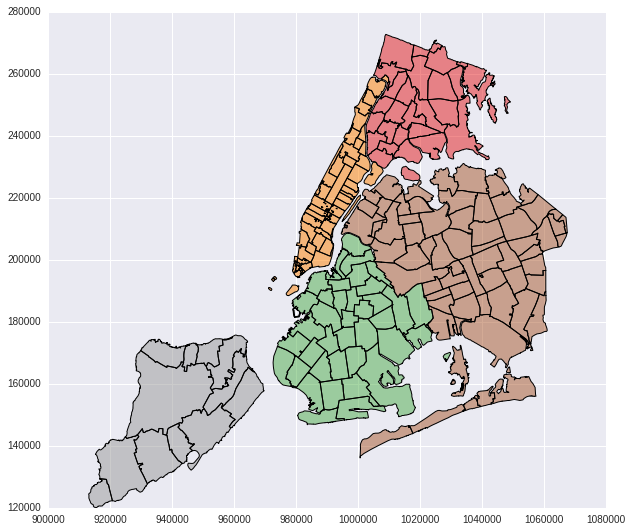

In [36]:
#Checking the shape file
newyork.plot(figsize = (10,10), column = 'COUNTY')

In [14]:
#merging datasets
newyork['ZIPCODE']=newyork['ZIPCODE'].astype(int)

In [16]:
df_final = pd.merge(facilities, newyork, how='left', left_on='zipcodes', right_on='ZIPCODE')
df_final.head()

,count,zipcodes,AREA,BLDGZIP,COUNTY,CTY_FIPS,POPULATION,PO_NAME,SHAPE_AREA,SHAPE_LEN,STATE,ST_FIPS,URL,ZIPCODE,geometry
0,1699,10461,6.282406e+07,0,Bronx,005,50549.0,Bronx,0.0,0.0,NY,36,http://www.usps.com/,10461,"POLYGON ((1029230.779448971 251468.9475710541,..."
1,405,11373,4.265486e+07,0,Queens,081,101282.0,Elmhurst,0.0,0.0,NY,36,http://www.usps.com/,11373,"POLYGON ((1015508.538520813 204353.9663418829,..."
2,1698,10451,2.894411e+07,0,Bronx,005,44140.0,Bronx,0.0,0.0,NY,36,http://www.usps.com/,10451,"POLYGON ((1002809.989770979 240846.5980808884,..."
3,220,11691,8.392782e+07,0,Queens,081,60267.0,Far Rockaway,0.0,0.0,NY,36,http://www.usps.com/,11691,"POLYGON ((1054519.887991399 162245.7592198849,..."
4,246,11375,5.558777e+07,0,Queens,081,68555.0,Forest Hills,0.0,0.0,NY,36,http://www.usps.com/,11375,"POLYGON ((1024087.848133817 207717.1410459727,..."


In [17]:
df_final.drop([  u'AREA',    u'BLDGZIP',
           u'COUNTY',   u'CTY_FIPS', u'POPULATION',    u'PO_NAME',
       u'SHAPE_AREA',  u'SHAPE_LEN',      u'STATE',    u'ST_FIPS',
              u'URL',    u'ZIPCODE',], axis=1, inplace=True)


In [18]:
df_final.head()

,count,zipcodes,geometry
0,1699,10461,"POLYGON ((1029230.779448971 251468.9475710541,..."
1,405,11373,"POLYGON ((1015508.538520813 204353.9663418829,..."
2,1698,10451,"POLYGON ((1002809.989770979 240846.5980808884,..."
3,220,11691,"POLYGON ((1054519.887991399 162245.7592198849,..."
4,246,11375,"POLYGON ((1024087.848133817 207717.1410459727,..."


In [19]:
#Getting the centroids
df_final=gpd.GeoDataFrame(df_final)
df_final['geometry']=df_final.geometry.centroid
df_final.head()

,count,zipcodes,geometry
0,1699,10461,POINT (1028292.72437689 247902.4282787614)
1,405,11373,POINT (1017941.215480481 208485.1046661779)
2,1698,10451,POINT (1005358.961284301 238316.0675161843)
3,220,11691,POINT (1050360.772370908 158235.4624321515)
4,246,11375,POINT (1026858.206454871 201880.2234817908)


In [20]:
#Defining functions to get x and y coordinates 
def getX(pt):
    return pt.x
def getY(pt):
    return pt.y

In [21]:
centroidlist_x=map(getX,df_final['geometry'].centroid)
centroidlist_y=map(getY,df_final['geometry'].centroid)


In [23]:
#Creating a 3xN numpy array with x-location, y-location, number of dismissals
krigdata=np.zeros((len(df_final),3))
krigdata[:,2] = df_final['count']
for i in range(len(krigdata)):
    krigdata[:,0][i] = centroidlist_x[i]
    krigdata[:,1][i] = centroidlist_y[i]

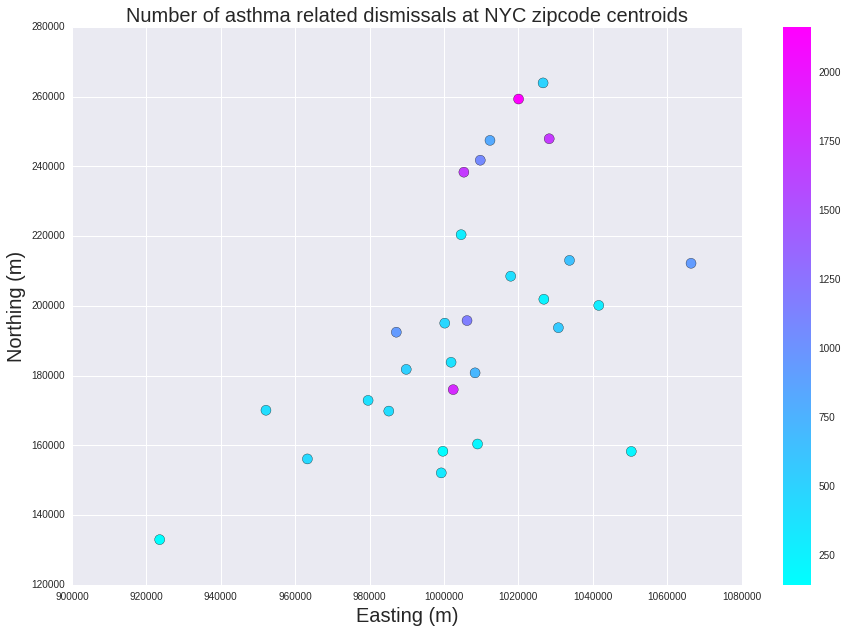

In [38]:
#Visualizing the data
pl.figure(figsize=(15,10))
pl.scatter(krigdata[:,0], krigdata[:,1], c=krigdata[:,2], s=100, cmap='cool')
pl.xlabel("Easting (m)", fontsize=20)
pl.ylabel("Northing (m)", fontsize=20)
pl.title('Number of asthma related dismissals at NYC zipcode centroids', fontsize = 20)
pl.colorbar()
pl.show()

#### Caption: The graph shows numbers of Asthma dismissals by location. The more violet the color the higher the count. Each point is graphed based on the centroid of the zipcode it stems from.

# Create and try to model the semi-variogram



In [26]:
# defining function 
#Code from: https://github.com/fedhere/UInotebooks/blob/master/kriging/kriging_porosity.ipynb
def SVh_vctzd( P, h, bw ):
    '''
    Experimental semivariogram for a single lag
    bw max distance
    h lag
    P data
    '''
    pdsv = squareform( pdist( P[:,:2] ) )
    #print pdsv
    N = pdsv.shape[0]
    #print N
    #print np.triu_indices(N)
    Z = np.zeros((N,N))
    Z = Z - P[:,2]
    #print Z
    Z = Z.T + P[:,2]
    #print Z
    Z = Z**2
    #print Z
    Zcd =  Z[(pdsv >= h - bw) * (pdsv <= h + bw) * \
            (~np.identity(N, dtype=bool))]

    #print Zcd
    return np.sum( Zcd ) / ( 2.0 * len( Zcd ) )

def SVh( P, h, bw ):
    '''
    Experimental semivariogram for a single lag
    bw max distance
    h lag
    P data
    '''
    #distance matrix (eucledian)
    pdsv = squareform( pdist( P[:,:2] ) )
    #print pdsv
    N = pdsv.shape[0]
    #print N

    Z = list()
    for i in range(N):
        for j in range(i+1, N):
            #select only pair of points at the appropriate lag
            if( pdsv[i,j] >= h - bw )and( pdsv[i,j] <= h + bw ):
                Z.append( ( P[i,2] - P[j,2] )**2.0 )
    #print Z
    return np.sum( Z ) / ( 2.0 * len( Z ) )


def SV( P, hs, bw ):
    '''
    Experimental variogram for a collection of lags
    '''
    sv = list()
    for h in hs:
        #print h
        sv.append( SVh( P, h, bw ) )
        #sv.append( SVh_vctzd ( P, h, bw ) )
    sv = [ [ hs[i], sv[i] ] for i in range( len( hs ) ) if sv[i] > 0 ]
    return np.array( sv ).T

## Working data

i am not sure about this part on hoe should i choose some numbers

In [29]:
# Calculating the maximum distance between two points
# Numbers visually gathered from data
y_dis = (80000-40000)
x_dis = (320000-280000)
max_dis = np.sqrt(x_dis**2 + y_dis**2)
print 'The maximum distance between points: %.2f'%max_dis

The maximum distance between points: 56568.54


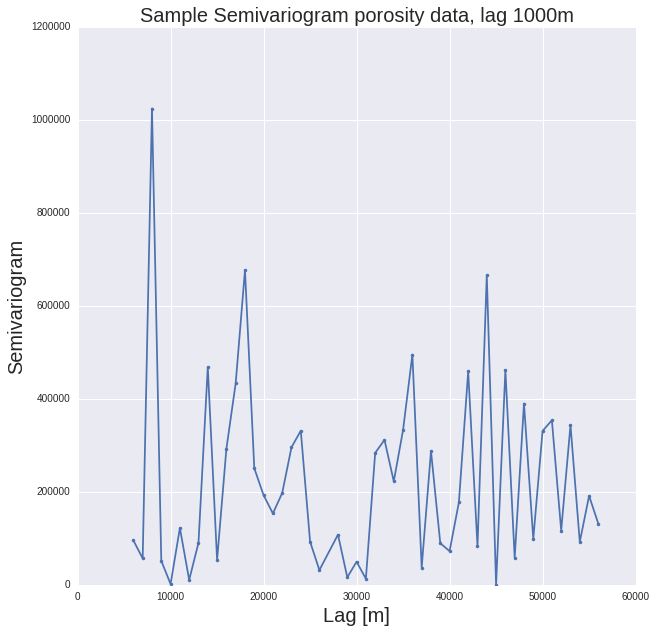

In [39]:
#Visualising the the semivariogram
lag = 1000
mysv = SV(krigdata, np.arange(1, max_dis, lag), 500)
pl.figure(figsize=(10,10))
pl.plot(mysv[0], mysv[1], '.-')
pl.plot(hs[0], hs[1], '--' )
pl.xlabel('Lag [m]', fontsize=20)
pl.ylabel('Semivariogram', fontsize=20)
pl.title('Sample Semivariogram porosity data, lag %dm'%lag, fontsize=20) 

### Caption: The semivariogram shows no similarity in the number of asthma dismissals based on the distance between zipcodes where these dismissals occur.

In [ ]:
#@Review: comment on what's happening, what you infer? See solution.